# Random Forest Model

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, roc_auc_score, r2_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


In [2]:
current_dir = Path.cwd()
data_dir = current_dir.parent / 'data' / 'processed' 
file_path = data_dir / 'Obesity_data_processed.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

In [6]:
# Separate the target variable
y = df['Obese_or_not']

# Drop the target variable from the features DataFrame
X = df.drop('Obese_or_not', axis=1)

In [7]:
ordinal_features = ['Province', 'Sex', 'Marital_status', 'Age', 'Working_12_months', 'Education_level', 
                    'Perceived_life_stress', 'Smoker', 'Drinker_12_months', 'Physical_activity', 
                    'Has_regular_healthcare_provider', 'Immigrant', 'Cultural_racial_background', 
                    'Food_security', 'Personal_income']

In [8]:
feature_orders = {
    'Province': ['NB', 'BC', 'ON', 'QUE', 'MN', 'AB', 'NL', 'PEI', 'NS', 'SASK'],
    "Sex": ["Female", "Male"],
    'Marital_status': ['Single', 'Common-law', 'Widow/Divorced/Sep', 'Married'],
    'Age': ['25 - 29', '20 - 24', '55 - 59', '35 - 39', '60 - 64', '40 - 44', '30 - 34', '50 - 54', '45 - 49'],
    'Working_12_months': ['Yes', 'No'],
    'Education_level': ['Less than secondary school graduation', 'Secondary school graduation only', 'Post-secondary diploma or uni degree'],
    'Perceived_life_stress': ['Not at all stressful', 'Not very stressful', 'A bit stressful', 'Quite a bit stressful', 'Extremely stressful'],
    'Smoker': ['Not at all', 'Occasionally', 'Daily'],
    'Drinker_12_months': ['Did not drink in the last 12 months', 'Occasional drinker', 'Regular drinker'],
    'Physical_activity': ["At/above rec'd level from CPAG", "Below rec'd level from CPAG", 'No physical activity'],
    'Has_regular_healthcare_provider': ['Yes', 'No'],
    'Immigrant': ['Immigrant', 'Canadian born'],
    'Cultural_racial_background': ['White', 'Non-white (other visible minority)', 'Aboriginal'],
    'Food_security': ['Food secure', 'Moderately food insecure', 'Severely food insecure'],
    'Personal_income': ['No income or income loss', 'Less than $20,000', '$20,000 - $39,999', '$40,000 - $59,999', '$60,000 - $79,999', '$80,000 or more']
}

X_ordinal = pd.DataFrame(df[ordinal_features])

categories_order = [feature_orders[feature] for feature in ordinal_features]

encoder = OrdinalEncoder(categories=categories_order)
X_ordinal_encoded = encoder.fit_transform(X_ordinal)
X_ordinal_encoded_df = pd.DataFrame(X_ordinal_encoded, columns=[f'{feat}_encoded' for feat in ordinal_features])

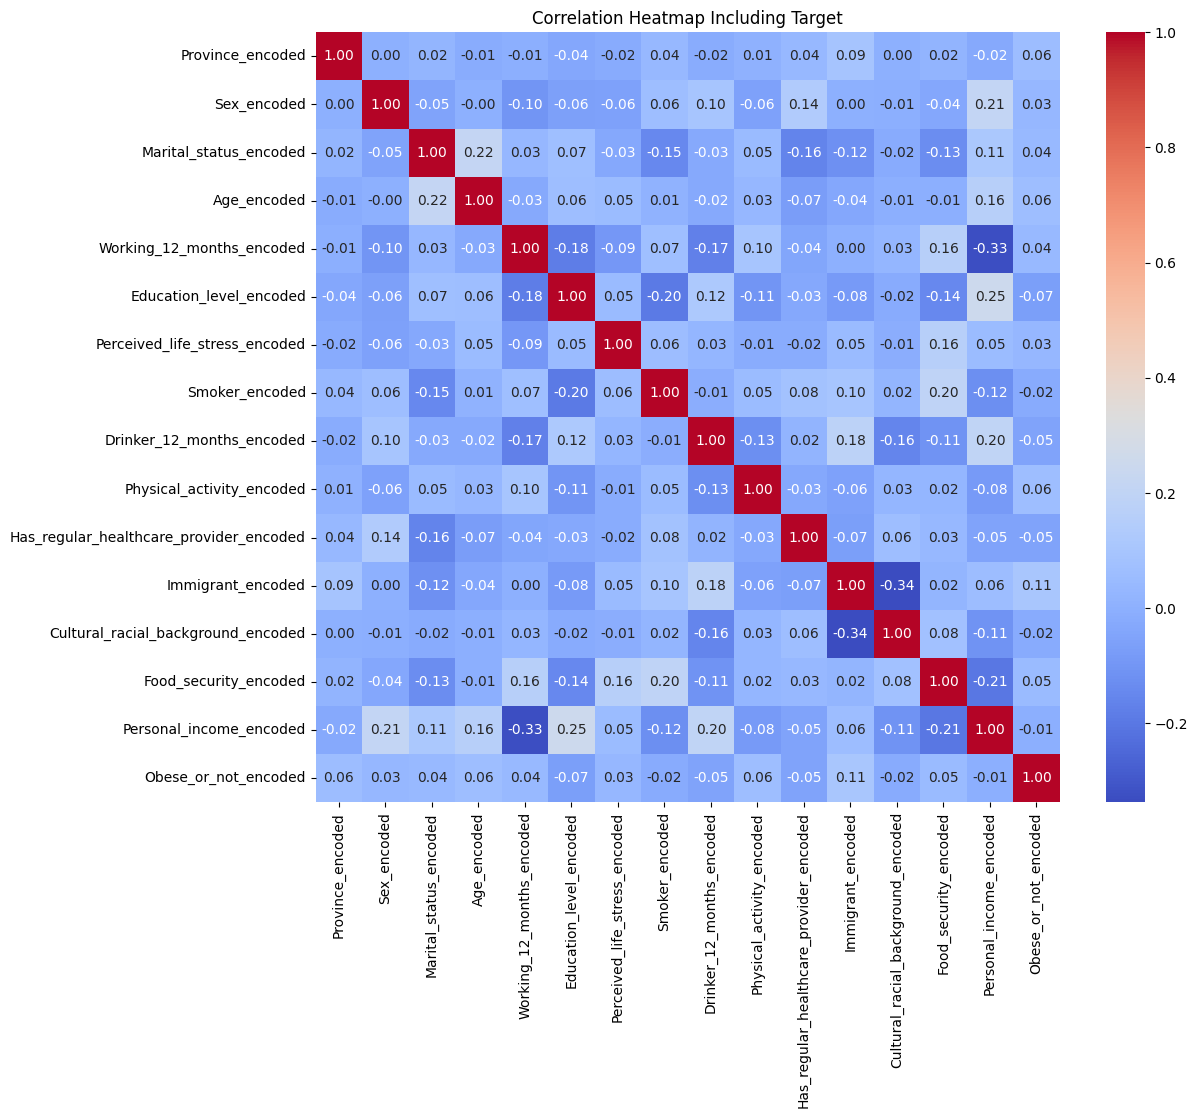

In [9]:
# HEATMAP WITH TARGET INCLUDED
target_encoding = {'Obese': 1, 'Not obese': 0}
df['Obese_or_not_encoded'] = df['Obese_or_not'].map(target_encoding)

# Assuming 'X_ordinal_encoded_df' is your DataFrame with encoded features
# Rename the DataFrame to reflect it includes both features and target
encoded_features_target_df = X_ordinal_encoded_df.copy()
encoded_features_target_df['Obese_or_not_encoded'] = df['Obese_or_not_encoded']

# Now 'encoded_features_target_df' contains all features plus the encoded target variable

correlation_matrix = encoded_features_target_df.corr(method='pearson')

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Correlation Heatmap Including Target')
plt.show()

## First Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded_df, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier with weights
model_rf = RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, random_state=42, n_jobs=-1)

# Train the model on the training data
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, n_jobs=-1,
                       random_state=42)

Accuracy: 0.6443696651346028
ROC AUC Score: 0.5842248582288777
              precision    recall  f1-score   support

   Not obese       0.70      0.83      0.76      8356
       Obese       0.39      0.23      0.29      3828

    accuracy                           0.64     12184
   macro avg       0.55      0.53      0.53     12184
weighted avg       0.61      0.64      0.61     12184



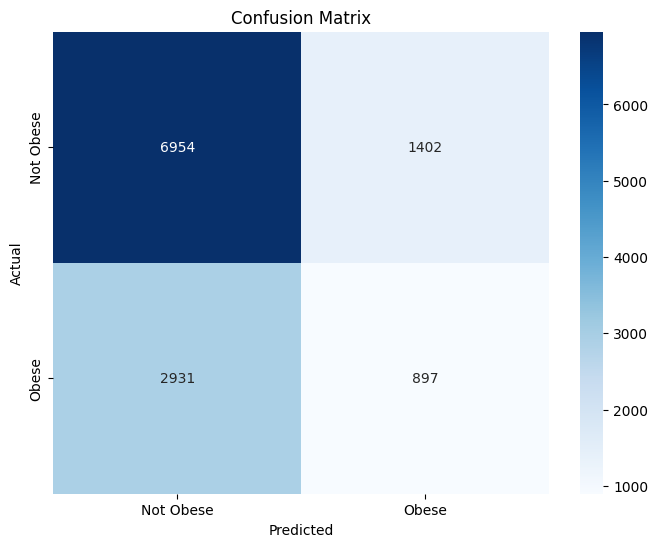

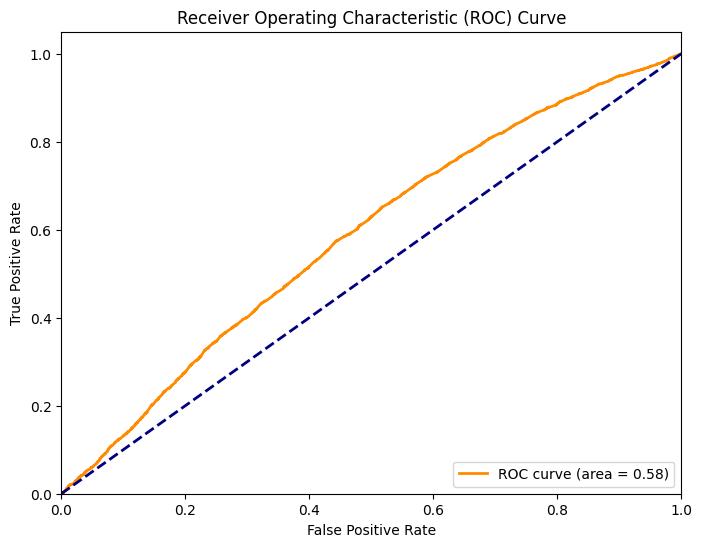

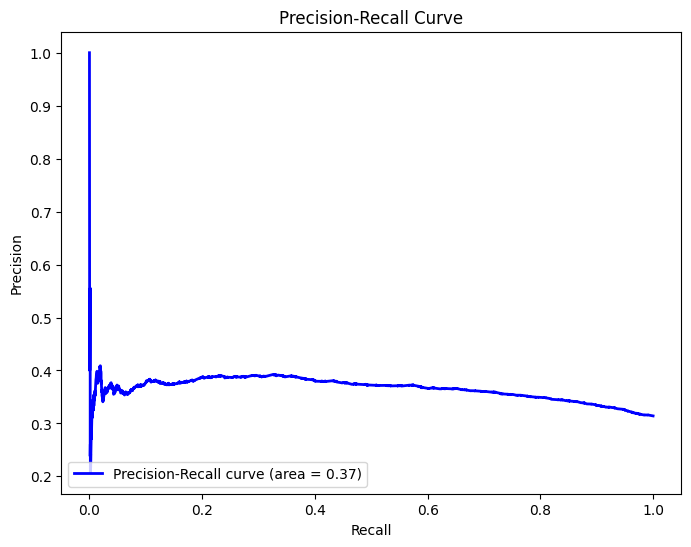

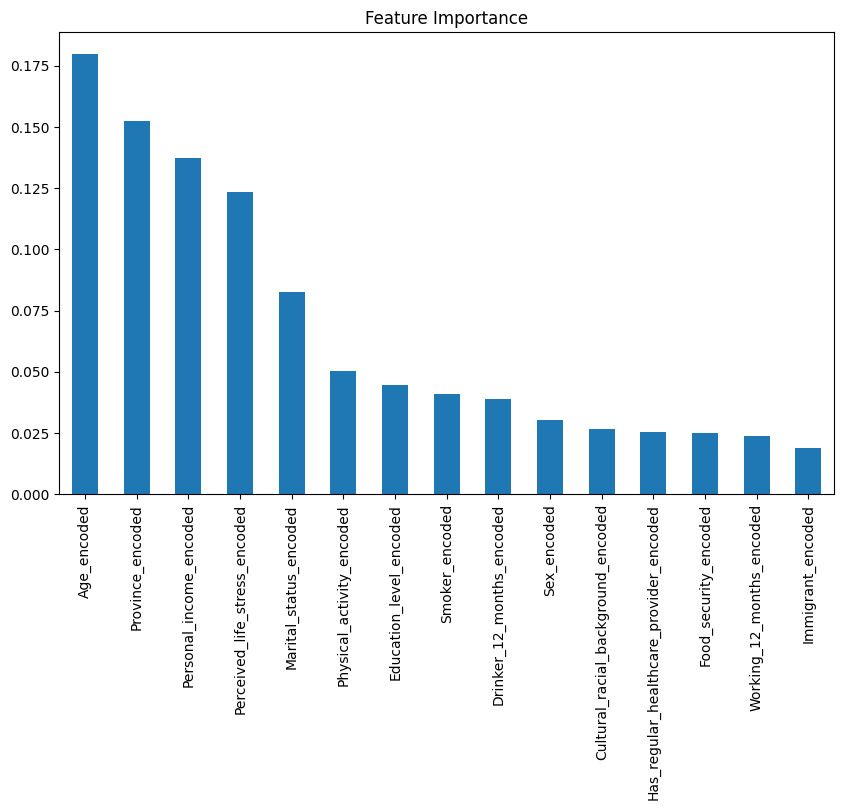

In [13]:
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

# Confusion Matrix Viz
cm = confusion_matrix(y_test, y_pred, labels=['Not obese', 'Obese'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='Obese')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label='Obese')
pr_auc = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Feature importance Plot
feature_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

## Feature Importance
Taller Bars: Indicate features that have more influence on the model's decisions. The model relies more heavily on these features for prediction.

## Model Performance Analysis
Accuracy (0.6443): My model correctly predicts the class (Obese or Not obese) 64.43% of the time. 

ROC AUC Score (0.5842): This score is close to 0.5, suggesting that the model's ability to distinguish between the "Obese" and "Not obese" classes is only slightly better than random guessing. 

Precision and Recall:

For "Not obese": The precision is relatively high at 0.70, indicating that when the model predicts "Not obese," it is correct 70% of the time. The recall is also high at 0.83, suggesting the model is good at identifying "Not obese" instances.
For "Obese": Both precision (0.39) and recall (0.23) are significantly lower, indicating difficulties in correctly identifying "Obese" instances and a higher rate of false positives when it does predict "Obese."

F1-Score:

The F1-score for "Obese" is 0.29, which is very low, indicating a poor balance between precision and recall.

Precision-Recall Curve Area (0.37): 
This further confirms the model's weakness with the "Obese" class.

## Next going to implement SMOTE to balance class distribution

In [17]:
from imblearn.over_sampling import SMOTE

# Assuming X_ordinal_encoded_df and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded_df, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Now I train a new Random Forest model on the balanced dataset
model_rf_smote = RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, random_state=42, n_jobs=-1)
model_rf_smote.fit(X_train_smote, y_train_smote)

# Make my predictions
y_pred_smote = model_rf_smote.predict(X_test)
y_pred_proba_smote = model_rf_smote.predict_proba(X_test)[:, 1]

# Evaluate my model
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_smote))
print(classification_report(y_test, y_pred_smote))

Accuracy: 0.6374753775443204
ROC AUC Score: 0.582810179509227
              precision    recall  f1-score   support

   Not obese       0.71      0.81      0.75      8356
       Obese       0.39      0.27      0.32      3828

    accuracy                           0.64     12184
   macro avg       0.55      0.54      0.54     12184
weighted avg       0.61      0.64      0.62     12184



## SMOTE Results:
Practically unchanged. Moving on to Hyperparameter Tuning.

In [18]:
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2]}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight={'Not obese': 1, 'Obese': 2}), 
                           param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit GS to the data:
grid_search.fit(X_train_smote, y_train_smote)

# Best hyperparameters:
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model found by GS:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_best))
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.6321405121470781
ROC AUC Score: 0.6010466421615338
              precision    recall  f1-score   support

   Not obese       0.72      0.76      0.74      8356
       Obese       0.40      0.35      0.37      3828

    accuracy                           0.63     12184
   macro avg       0.56      0.55      0.56     12184
weighted avg       0.62      0.63      0.62     12184



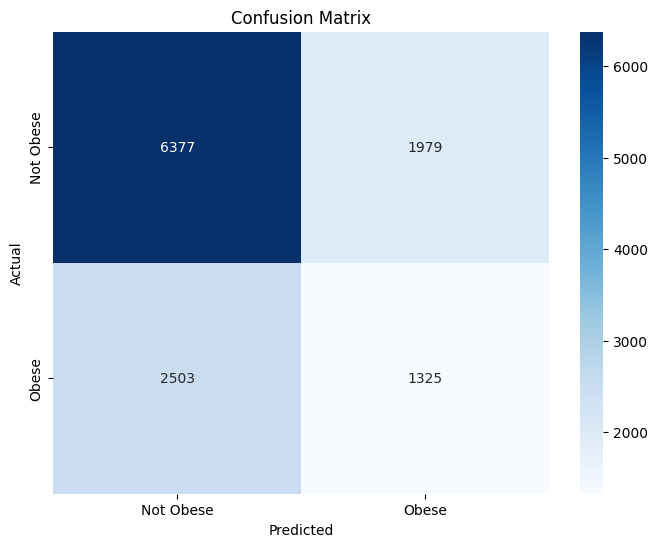

In [19]:
# Confusion Matrix Viz
cm = confusion_matrix(y_test, y_pred_best, labels=['Not obese', 'Obese'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## What does this confusion matrix show compared to previous one? 

## Automated Feature Selection:
- Will keep only the most important features.

In [20]:
from sklearn.feature_selection import SelectFromModel

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than a specified threshold (e.g., mean of importances)
selector = SelectFromModel(model_rf_smote, threshold='mean')
selector.fit(X_train_smote, y_train_smote)

# Transform training and testing sets so only the selected features are retained
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)

# Retrain the model using only the selected features
model_rf_selected = RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, random_state=42, n_jobs=-1)
model_rf_selected.fit(X_train_selected, y_train_smote)

# Evaluate the new model
y_pred_selected = model_rf_selected.predict(X_test_selected)
y_pred_proba_selected = model_rf_selected.predict_proba(X_test_selected)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_selected))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_selected))
print(classification_report(y_test, y_pred_selected))


Accuracy: 0.5281516743269862
ROC AUC Score: 0.5465234561991383
              precision    recall  f1-score   support

   Not obese       0.71      0.52      0.60      8356
       Obese       0.34      0.54      0.42      3828

    accuracy                           0.53     12184
   macro avg       0.53      0.53      0.51     12184
weighted avg       0.60      0.53      0.55     12184



## Results:
- Even worse.

## Try using onyl top 5 Features: 

In [25]:
feature_importances_sorted = feature_importances.sort_values(ascending=False)

top_5_features = feature_importances_sorted.head(5).index.tolist()
print("Top 5 features:", top_5_features)

Top 5 features: ['Age_encoded', 'Province_encoded', 'Personal_income_encoded', 'Perceived_life_stress_encoded', 'Marital_status_encoded']


In [26]:
X_top_5 = X_ordinal_encoded_df[top_5_features]

X_train_top_5, X_test_top_5, y_train, y_test = train_test_split(X_top_5, y, test_size=0.2, random_state=42)

In [27]:
model_top_5 = RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, random_state=42, n_jobs=-1)

model_top_5.fit(X_train_top_5, y_train)

RandomForestClassifier(class_weight={'Not obese': 1, 'Obese': 2}, n_jobs=-1,
                       random_state=42)

In [28]:
y_pred_top_5 = model_top_5.predict(X_test_top_5)
y_pred_proba_top_5 = model_top_5.predict_proba(X_test_top_5)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_top_5))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_top_5))
print(classification_report(y_test, y_pred_top_5))

Accuracy: 0.5849474720945502
ROC AUC Score: 0.5544832475728714
              precision    recall  f1-score   support

   Not obese       0.71      0.67      0.69      8356
       Obese       0.36      0.40      0.38      3828

    accuracy                           0.58     12184
   macro avg       0.53      0.53      0.53     12184
weighted avg       0.60      0.58      0.59     12184



## Results: 
- Basically no difference